In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#The data relevant to our research question is in the following two files. Note these contain background information about patients (age, sex, etc), as well as information obtained at the paitent's arrival at the ED. 
# Although there is other data available, it is obtained later in the patient's ED stay.
edstays = pd.read_csv('MIMIC_data/edstays.csv.gz', compression='gzip')
triage = pd.read_csv('MIMIC_data/triage.csv.gz', compression='gzip')

In [5]:
# Merge these two dataframes along the stay_id column.
df=pd.merge(edstays, triage, how='outer', on='stay_id')

#Eliminate the duplicate and simplify variable name:
df.rename(columns={'subject_id_x': 'subject_id'}, inplace=True)
df.drop('subject_id_y', axis=1, inplace=True)


In [6]:
#Here I have added extra variables, day of the week and time of day, for the intime. 
#The date information has a random shift to preserve anonymity, so these variables can't be used.
#df['day_of_week_intime'] = pd.to_datetime(df['intime']).dt.dayofweek
#df['time_of_day_intime'] = pd.to_datetime(df['intime']).dt.time

In [7]:
#Here I compute the target variable, stay length, in terms of hours.
df['stay_length']=pd.to_datetime(df['outtime'])-pd.to_datetime(df['intime'])
df['stay_length_hours']= df['stay_length'].dt.total_seconds() / 3600

#Now I can drop the 'stay_length' variable.
df.drop('stay_length', axis=1, inplace=True)

Cleaning work starts here.

In [8]:
#First, let's take a look at the target variable, stay_length_hours.

df['stay_length_hours'].describe()

count    425087.000000
mean          7.158327
std           6.628000
min         -22.733333
25%           3.533333
50%           5.466667
75%           8.316667
max         493.069444
Name: stay_length_hours, dtype: float64

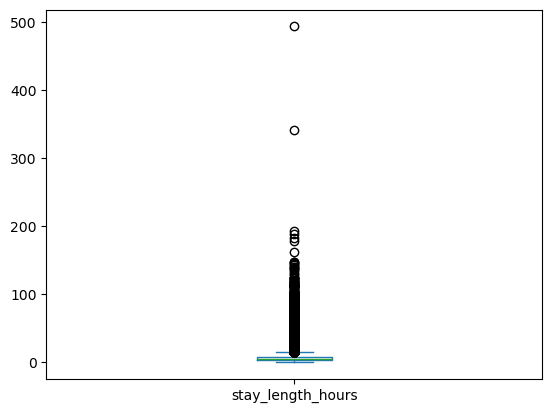

In [9]:
#There are some values for stay_length_hours, which are negative. This is nonsensical. We remove them.

df = df[df['stay_length_hours'] >= 0]

#We should also remove extreme high values for length of stay, as these are probably inaccurate. Looking at the graph, it seems we have a clear break
#between the two most extreme outliers and the rest of the data, so I am just cutting out the two high values. 
#May want to revise this cut-off.

df['stay_length_hours'].plot(kind='box')

df = df[df['stay_length_hours'] <= 300]

In [10]:
#Now let's look at each variable more closely.

df.describe()

,subject_id,hadm_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,stay_length_hours
count,4.250790e+05,2.030140e+05,4.250790e+05,401664.000000,407989.000000,404726.000000,404483.000000,406789.000000,405989.000000,418092.000000,425079.000000
mean,1.500873e+07,2.499499e+07,3.499737e+07,98.015054,85.079971,17.565532,98.471907,135.395407,81.262128,2.625092,7.156703
std,2.878475e+06,2.888739e+06,2.888331e+06,4.008614,18.041731,5.485734,17.040968,240.958472,1057.229145,0.708079,6.565501
min,1.000003e+07,2.000002e+07,3.000001e+07,0.100000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.251793e+07,2.248985e+07,3.249802e+07,97.500000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,3.533333
50%,1.501632e+07,2.499939e+07,3.499401e+07,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,5.466667
75%,1.749900e+07,2.749390e+07,3.750391e+07,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,8.316667
max,1.999999e+07,2.999981e+07,3.999996e+07,986.000000,1228.000000,1820.000000,9322.000000,151103.000000,661672.000000,5.000000,192.566667


In [11]:
#Note that the various input variables have values that are physically impossible. We'll need to address each of these
# Let's start with temperature. Here, the max value recorded is 986.000, and the minimum is 0.1. Both of these are physically impossible. 

#First let's look for values where the decimal point may have been moved to the left one place in error.  
# I started with the assumption that values should be between 82.4 F (lower cut-off for moderate hypothermia 
# according to https://my.clevelandclinic.org/health/diseases/21164-hypothermia-low-body-temperature) and 110 F. 
# Note that there are 44 of these, and some of them would certainly be normal temperatures with a move in decimal place. 
# I replace these values with their value multiplied by 10.

filtered_values = df[(df['temperature'] >= 8.24) & (df['temperature'] <= 10.10)]['temperature']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['temperature'] >= 8.24) & (df['temperature'] <= 10.10), 'temperature'] *= 10

44
30497      8.80
37682      9.00
48915      9.40
57420      9.10
63041      9.80
63134      9.00
68023      9.00
72974      9.70
80024      9.20
90363      8.40
99394      9.50
104910     9.00
110887     9.80
112636     9.00
113407     9.00
115550     9.60
119192     9.00
124773     9.60
138646     9.80
157582     9.00
168211     9.40
180822    10.00
181794     9.00
190344     9.10
192237     9.10
192917     9.10
193734     9.60
195015     8.40
199376     9.00
207364     9.10
208990     9.00
216460     9.00
219589     9.50
268045     8.60
276287     9.60
282379     9.50
313908     9.70
322975     9.83
331676     9.00
348233     9.00
368614     9.00
388628     8.60
389857     9.90
416869     9.80
Name: temperature, dtype: float64


In [12]:
#Next let's consider values where the decimal point may have been moved one place to the right in error. 

filtered_values = df[(df['temperature'] >= 824) & (df['temperature'] <= 1010)]['temperature']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['temperature'] >= 824) & (df['temperature'] <= 1010), 'temperature'] *= .10

5
31824     981.0
126529    978.0
161723    977.0
364451    979.0
366200    986.0
Name: temperature, dtype: float64


In [13]:
# Next we look for values that may be in Celsius, using the same cut-off as above: 28 C= 82.4 F and 43.3 C=110 F. 
# Note that the documentation for the data indicates that some of the temperature data may be in Celsius.

filtered_values = df[(df['temperature'] >= 28) & (df['temperature'] <= 43.3)]['temperature']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['temperature'] >= 28) & (df['temperature'] <= 43.3), 'temperature'] = df['temperature'] * 9/5 + 32


391
976       36.1
4074      36.9
5274      37.6
5407      36.9
5533      36.1
          ... 
420423    36.4
422050    36.7
422906    36.3
422979    36.5
423337    36.0
Name: temperature, Length: 391, dtype: float64


In [14]:
# The above work addresses all of the issues that I can think of. So now for any values that are below 82.4 or above 110, 
# I assume they are a mistake that I can't fix and replace them with NaN.

filtered_values = df[(df['temperature'] > 110) | (df['temperature'] < 82.4)]['temperature']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['temperature'] > 110) | (df['temperature'] < 82.4), 'temperature'] = np.nan


87
3569       62.0000
5938      111.4000
7149       75.9000
9674        7.8000
14522       7.6000
            ...   
404703     77.7778
405941      1.0400
414134     80.0000
419804      7.2000
420497      6.0000
Name: temperature, Length: 87, dtype: float64


In [15]:
#Now let's consider heart rate. There are some very high values, but from my internet search, it seems these could be real values of someone experiencing a medical emergency. 
# So I am not going to do anything about them. There are no negative values reported for heart rate.

df['resprate'].describe()

count    404726.000000
mean         17.565532
std           5.485734
min           0.000000
25%          16.000000
50%          18.000000
75%          18.000000
max        1820.000000
Name: resprate, dtype: float64

In [16]:
#resprate: There are some very large values which appear to be physically impossible. (My cut-off of 300 here is a guess by me about what is reasonable. I could not find information about what values 
# might be possible for human beings.) There is no obvious error here (like a misplaced decimal), so I am replacing these with NaN's.

filtered_values = df[(df['resprate'] > 300)]['resprate']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['resprate'] > 300), 'resprate'] = np.nan

3
53010     1796.5
359661    1820.0
401104    1797.9
Name: resprate, dtype: float64


In [17]:
#Eliminate O2sat above 100. 
df.loc[(df['o2sat'] > 100), 'o2sat'] = np.nan

#sbp: systolic blood pressure. The internet indicated that a sbp of 1000 could be possible, but unlikely and fatal. Looking at the data, there are a few values that are large than 1000 by at least a factor of 10. 
# I am guessing these are errors and replacing with NaN.

filtered_values = df[(df['sbp'] > 1000)]['sbp']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['sbp'] > 1000), 'sbp'] = np.nan

4
113412     19734.0
126529     12080.0
266542    151103.0
365075      9656.0
Name: sbp, dtype: float64


In [18]:
#dbp: diastolic blood pressure. I'll use the same criterion as above, eliminating values above 1000, although this is likely too high a cut-off. Note that there are many more dbp that fall above this cut-off.

filtered_values = df[(df['dbp'] > 1000)]['dbp']

print(len(filtered_values))

print(filtered_values)

df.loc[(df['dbp'] > 1000), 'sbp'] = np.nan

#Note that there are some instances where sbp is smaller than dbp. This is nonsensical, but it's not clear what to do with these cases.

101
1571      6698.0
3037      3108.0
3195      8102.0
3642      3101.0
3888      6113.0
           ...  
408900    7288.0
413318    7297.8
420108    9102.0
420779    9556.0
422808    1102.0
Name: dbp, Length: 101, dtype: float64


In [19]:
#Now we consider 'pain.' Although the pain variable is described as a numerical score between 0 and 10, the actual data contains many text entries
#and values outside of the stated range.
print(df['pain'].unique())
print(len(df['pain'].unique()))

['0' '2' '9' '3' '10' '7' '8' '5' '6' '13' '1' nan '4' '6.5' 'UTA' '6-7'
 'unable' 'Critical' 'UA' 'balit' '00' 'mucho' 'ua' 'Unable' 'c' '8.5'
 'uta' 'critical' '20' '5/9' 'dull' 'denies' '9-10' 'bad' '3-4' 'unable '
 'ett' 'not to bad' '25' '3.5' 'unable to assess' 'alot' 'not too bad'
 '97' '9.5' '"pain"' 'u/a' '5.5' '12' '15' 'not bad' '5-6' '14' 'crit'
 'crit ' '"alot"' 'asleep' '19' '0-2' '1-2' 'UNABLE' '1/2' '4-5' '2-3'
 '70' 'Non-verbal' 'it hurts' 'na' 'hurts alot' 'manageable' 'mild'
 'achey' 'burning' '10/' 'REF' '11' '9.5-10' 'yes' 'bone pain'
 'unable to obtain' '8-9' 'through the roof' '069' 'cramping' 'moderate'
 'sleeping' 'refusing' 'u' '1.5' 'somulent' 'unalbe' 's' '7.5' 'uable'
 '7.235' 'prehosp' 'pressure' '"a little"' 'mild aches ' 'a little'
 'little' '"15"' '4.5' '7-8' '5-10' 'L chest' '9-8' 'Unresponsive' '0-'
 'unknown' 'unqble' '10+' 'refused' '60' '"bad"' '"a lot"' '?' 'nonverbal'
 '03' '7.5-8' '10 ' 'tiny bit' 'unable to access' '"a little more"'
 'not that 

In [20]:
#THe simplest thing we can do to make this variable useable while still preserving the information is to through out all text information 
#as well as all numerical values outside the range 0-10.
 
#Check how many NaN entries we have.
print("NaN entries before cleaning:")
print(df['pain'].isna().sum())

#This takes all non-numeric entries to NaN.
df['pain_cleaned']=pd.to_numeric(df['pain'], errors='coerce')

print("NaN entries after removing text entries:")
print(df['pain_cleaned'].isna().sum())

#This sends numerical entries outside of range to NaN.
df.loc[~((df['pain_cleaned'] <=10) & (df['pain_cleaned'] >=0)), 'pain_cleaned'] = np.nan

print("NaN entries after removing outside range:")
print(df['pain_cleaned'].isna().sum())

NaN entries before cleaning:
12933
NaN entries after removing text entries:
28112
NaN entries after removing outside range:
39316


In [21]:
import re

In [22]:
#But I could be more clever about this cleaning, although the results may be less reliable. Here, I will try to clean up any entries that 
# involve any numbers at all.

# Function to transform pain entries based on format:
def pain_cleaner(entry):
    # Check if it's a range (number-number). For example, 6-9. I will replace this range by the average of the endpoints of the range.
    if isinstance(entry, str) and '-' in entry:
        try:
            # Split the string at the hyphen and calculate the average of the two numbers. Round down to 10 if the result is larger than 10.
            num1, num2 = map(int, entry.split('-'))
            num=(num1 + num2) / 2
            if num > 10: #Round down to 10 if the result is larger than 10.
                num=10
            return num
        except ValueError:
            return np.nan  # If the split values are not integers, return NaN
    
    # Check if it's a number followed by a symbol (e.g., '9+'). In this case, I will strip off the extra symbols and just keep the number.
    match = re.match(r'(\d+(\.\d+)?)\D*$', str(entry))  # Matches a number followed by any non-digit symbol(s)
    if match:
        num=float(match.group(1))  # Return the numeric part as a float. Round down to 10 if the result is larger than 10.
        if num > 10:
            num=10
        return num
    # Check if it's a single number
    try:
        num=float(entry)  # Try converting to a float (covers integer and decimal). Round down to 10 if the result is larger than 10.
        if num > 10:
            num=10
        return num
    except ValueError:
        return np.nan  # If it's not a number, return NaN

# Apply the transformation function to the column
df['pain_cleaned_advanced'] = df['pain'].apply(pain_cleaner)

print("NaN entries after cleaning:")
print(df['pain_cleaned_advanced'].isna().sum())


NaN entries after cleaning:
27047


In [23]:
#We have a lot of race categories and this is too many for at least some model types. 
#(We couldn't reasonbly use this for linear regression, for example.) So we will collapse the categories into 
# the standard race/ethnicity categories used in the US.
print(df['race'].unique())
print(len(df['race'].unique()))

['WHITE' 'BLACK/AFRICAN AMERICAN' 'OTHER' 'HISPANIC/LATINO - PUERTO RICAN'
 'ASIAN - SOUTH EAST ASIAN' 'ASIAN - ASIAN INDIAN'
 'HISPANIC/LATINO - DOMINICAN' 'HISPANIC/LATINO - SALVADORAN'
 'BLACK/CARIBBEAN ISLAND' 'ASIAN' 'HISPANIC/LATINO - MEXICAN'
 'WHITE - OTHER EUROPEAN' 'WHITE - EASTERN EUROPEAN' 'WHITE - BRAZILIAN'
 'UNKNOWN' 'HISPANIC OR LATINO' 'SOUTH AMERICAN' 'ASIAN - CHINESE'
 'BLACK/CAPE VERDEAN' 'HISPANIC/LATINO - HONDURAN'
 'HISPANIC/LATINO - GUATEMALAN' 'BLACK/AFRICAN' 'WHITE - RUSSIAN'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' 'PORTUGUESE'
 'HISPANIC/LATINO - COLUMBIAN' 'HISPANIC/LATINO - CUBAN'
 'AMERICAN INDIAN/ALASKA NATIVE' 'UNABLE TO OBTAIN'
 'PATIENT DECLINED TO ANSWER' 'ASIAN - KOREAN'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'MULTIPLE RACE/ETHNICITY']
33


In [24]:
#This functions collapses the race categories into white, Black, Asian, Hispanic/Latino, etc.

def race_cleaner(entry):
    if 'ASIAN' in entry:
        return 'ASIAN'
    elif 'WHITE' in entry:
        return 'White'
    elif 'HISPANIC' in entry:
        return 'HISPANIC/LATINO'
    elif 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' in entry:
        return 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
    elif 'AMERICAN INDIAN/ALASKA NATIVE' in entry:
        return 'AMERICAN INDIAN/ALASKA NATIVE'
    elif 'BLACK' in entry:
        return 'BLACK'
    elif entry in ['OTHER','MULTIPLE RACE/ETHNICITY','SOUTH AMERICAN', 'PORTUGUESE']:
        return 'OTHER'
    else:
        return np.nan
    
# Apply the transformation function to the column
df['race_condensed'] = df['race'].apply(race_cleaner)

In [25]:
#Counts for the original categories.
df['race'].value_counts()

race
WHITE                                        228118
BLACK/AFRICAN AMERICAN                        76796
OTHER                                         20751
HISPANIC/LATINO - PUERTO RICAN                14036
WHITE - OTHER EUROPEAN                         8992
HISPANIC/LATINO - DOMINICAN                    8330
BLACK/CAPE VERDEAN                             7638
ASIAN - CHINESE                                7348
ASIAN                                          7294
UNKNOWN                                        7083
WHITE - RUSSIAN                                6091
BLACK/AFRICAN                                  4887
BLACK/CARIBBEAN ISLAND                         3675
HISPANIC OR LATINO                             3141
HISPANIC/LATINO - GUATEMALAN                   2356
ASIAN - ASIAN INDIAN                           1567
ASIAN - SOUTH EAST ASIAN                       1533
HISPANIC/LATINO - SALVADORAN                   1497
WHITE - BRAZILIAN                              1484
PORTUGU

In [26]:
#Counts for the new race_condensed variable.
print(df['race_condensed'].value_counts())
print(df['race_condensed'].isna().sum())

race_condensed
White                                        245997
BLACK                                         92996
HISPANIC/LATINO                               34511
OTHER                                         23552
ASIAN                                         18528
AMERICAN INDIAN/ALASKA NATIVE                  1037
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       507
Name: count, dtype: int64
7951


In [27]:
#Check basic summary statistics to make sure it looks like all of the cleaning worked.
df.describe()

,subject_id,hadm_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,stay_length_hours,pain_cleaned,pain_cleaned_advanced
count,4.250790e+05,2.030140e+05,4.250790e+05,401577.000000,407989.000000,404723.000000,404436.000000,406684.000000,405989.000000,418092.000000,425079.000000,385763.000000,398032.000000
mean,1.500873e+07,2.499499e+07,3.499737e+07,98.083969,85.079971,17.552284,98.375138,134.937554,81.262128,2.625092,7.156703,4.166849,4.334821
std,2.878475e+06,2.888739e+06,2.888331e+06,0.975244,18.041731,2.532867,2.457084,22.669486,1057.229145,0.708079,6.565501,3.754275,3.822145
min,1.000003e+07,2.000002e+07,3.000001e+07,82.400000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-0.000000,0.000000
25%,1.251793e+07,2.248985e+07,3.249802e+07,97.500000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,3.533333,0.000000,0.000000
50%,1.501632e+07,2.499939e+07,3.499401e+07,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,5.466667,4.000000,5.000000
75%,1.749900e+07,2.749390e+07,3.750391e+07,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,8.316667,8.000000,8.000000
max,1.999999e+07,2.999981e+07,3.999996e+07,110.000000,1228.000000,209.000000,100.000000,960.000000,661672.000000,5.000000,192.566667,10.000000,10.000000


In [28]:
df['disposition'].value_counts()

disposition
HOME                           241627
ADMITTED                       158008
TRANSFER                         7025
LEFT WITHOUT BEING SEEN          6154
ELOPED                           5710
OTHER                            4297
LEFT AGAINST MEDICAL ADVICE      1881
EXPIRED                           377
Name: count, dtype: int64

In [29]:
#hadm_id is a code for admission to the hospital from the ED. This information is not relevant to our work, so I am dropping it.
#We actually need the hadm_id variable to merge with the HOSP data, so leave this in for now.
#df.drop('hadm_id', axis=1, inplace=True)

#Also, we are not going to make predictions for when the disposition (that is, means of leaving the hospital) is 'eloped', 'left without being seen', 
#'left against medical advice'. We also shouldn't use the variable 'disposition' as part of the predictor variable set, so I am going to drop it.
df = df[~df['disposition'].isin(['ELOPED','LEFT WITHOUT BEING SEEN', 'LEFT AGAINST MEDICAL ADVICE'])]
df.drop('disposition', axis=1, inplace=True)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train, test= train_test_split(df, shuffle = True, random_state = 489,test_size=.1)

In [32]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [33]:
print(len(df['subject_id'].unique()))
print(len(df['stay_id'].unique()))

201695
411334


In [34]:
counts=df['subject_id'].value_counts()
counts.describe()

count    201695.000000
mean          2.039386
std           3.174314
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         276.000000
Name: count, dtype: float64